
# Simulator-based unsupervised detection and tracking of worms

**References**

    1. Wu, Hao, et al. Amortized population Gibbs samplers with neural
       sufficient statistics. ICML 2020.

<img src="file://../_static/wormsim.gif" align="center">


In [1]:
import argparse
from functools import partial

import coix
import flax.linen as nn
import jax
from jax import random
import jax.numpy as jnp
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import optax
from optax import cosine_decay_schedule
from optax import clip_by_global_norm
import tensorflow as tf
import tensorflow_datasets as tfds

from sim_utils import *

/home/frans/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-14 18:51:32.995376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 18:51:33.011006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 18:51:33.015670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 18:51:33.682471: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fi

In [2]:
def dataset_generator(file_path, n_data=-1):
    ds = np.load(file_path, mmap_mode='r')
    ds = ds[:n_data] if n_data != -1 else ds
    for data in ds:
        yield data

def load_dataset(*, is_training, batch_size, n_data=-1, file_path="worms_train_40k.npy"):
    # Create a dataset from the generator
    ds = tf.data.Dataset.from_generator(
        dataset_generator,
        args=(file_path, n_data),
        output_signature=tf.TensorSpec(shape=(None, None, None), dtype=tf.float32)
    )
    
    ds = ds.repeat()
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    
    # Standardize the data between 0 and 1
    ds = ds.map(lambda x: x / 0.80999994)
    return iter(tfds.as_numpy(ds))

In [3]:
def vmapped_sim_fn(sim_fn, params):
    if params['L'].ndim == 1:
        return jax.vmap(sim_fn, in_axes=0, out_axes=0)(params)
    else:
        return jax.vmap(partial(vmapped_sim_fn, sim_fn), in_axes=0, out_axes=0)(params)

In [4]:
def sim_worms(nworms, n_frames):
    duration = 1.55
    snapshots = 10
    kpoints = 6
    box_size = 64
    L_low = 23
    L_high = 28
    L = numpyro.sample('L', dist.Uniform(L_low, L_high).expand([nworms]).to_event())
    A = numpyro.sample('A', dist.Normal(1, 0.1).expand([nworms]).to_event())
    T = numpyro.sample('T', dist.Normal(0.8, 0.1).expand([nworms]).to_event())
    kw = numpyro.sample('kw', dist.Uniform(0, 2 * jnp.pi).expand([nworms]).to_event())
    ku = numpyro.sample('ku', dist.Normal(jnp.pi, 1).expand([nworms]).to_event())

    inc = numpyro.sample('inc', dist.Uniform(0, 2 * jnp.pi).expand([nworms]).to_event())
    dr = numpyro.sample('dr', dist.Uniform(0.2, 0.8).expand([nworms]).to_event())
    phase_1 = numpyro.sample('phase_1', dist.Uniform(0, 2 * jnp.pi).expand([nworms]).to_event())
    phase_2 = numpyro.sample('phase_2', dist.Uniform(0, 2 * jnp.pi).expand([nworms]).to_event())
    phase_3 = numpyro.sample('phase_3', dist.Normal(0, 0.1).expand([nworms]).to_event())
    alpha = numpyro.sample('alpha', dist.Normal(4, 4).expand([nworms]).to_event())
    alpha = jnp.abs(alpha + 1.0)

    x0 = jnp.zeros_like(L)
    y0 = jnp.zeros_like(L)

    params = {'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha, 'x0': x0, 'y0': y0}
    sim_fn = partial(
        worm_simulation,
        duration=duration,
        snapshots=snapshots,
        kpoints=kpoints,
    )
    worms = vmapped_sim_fn(sim_fn, params)
    worms = worms / ((L_high + L_low) / 2)
    numpyro.deterministic('worms', worms)
    return worms, params

In [5]:
def scale_and_translate(image, where, out_size):
  translate = abs(image.shape[-1] - out_size) * (where[..., ::-1] + 1) / 2
  return jax.image.scale_and_translate(
      image,
      (out_size, out_size),
      (0, 1),
      jnp.ones(2),
      translate,
      method="cubic",
      antialias=False,
  )

def scale_and_translate_variable_scale(image, where, scale, out_size):
  translate = abs(image.shape[-1] - out_size) * (where[..., ::-1] + 1) / 2
  return jax.image.scale_and_translate(
      image,
      (out_size, out_size),
      (0, 1),
      scale * jnp.ones(2),
      translate,
      method="cubic",
      antialias=False,
  )

def crop_frames(frames, z_where, digit_size=28):
  # frames:           time.frame_size.frame_size
  # z_where: (worm_frames).time.2
  # out:     (digits).time.digit_size.digit_size
  if frames.ndim == 2 and z_where.ndim == 1:
    return scale_and_translate(frames, z_where, out_size=digit_size)
  elif frames.ndim == 3 and z_where.ndim == 2:
    in_axes = (0, 0)
  elif frames.ndim == 4 and z_where.ndim == 3:
    in_axes = (0, 0)
  elif frames.ndim == 2 and z_where.ndim == 2:
    in_axes = (None, 0)
  elif frames.ndim == z_where.ndim:
    in_axes = (0, 0)
  elif frames.ndim > z_where.ndim:
    in_axes = (0, None)
  else:
    in_axes = (None, 0)
  return jax.vmap(partial(crop_frames, digit_size=digit_size), in_axes)(
      frames, z_where
  )


def embed_frames(worm_frames, z_where, frame_size=64):
  # worm_frames:  (worm_frames).      .digit_size.digit_size
  # z_where: (worm_frames).(time).2
  # out:     (worm_frames).(time).frame_size.frame_size
  if worm_frames.ndim == 2 and z_where.ndim == 1:
    return scale_and_translate(worm_frames, z_where, out_size=frame_size)
  elif worm_frames.ndim == 2 and z_where.ndim == 2:
    in_axes = (None, 0)
  elif worm_frames.ndim >= z_where.ndim:
    in_axes = (0, 0)
  else:
    in_axes = (None, 0)
  return jax.vmap(partial(embed_frames, frame_size=frame_size), in_axes)(
      worm_frames, z_where
  )

def embed_worms(worm_frames, z_where, scale, frame_size=64):
  # worm_frames:  (worm_frames).      .digit_size.digit_size
  # z_where: (worm_frames).(time).2
  # out:     (worm_frames).(time).frame_size.frame_size
  if worm_frames.ndim == 2 and z_where.ndim == 1:
    return scale_and_translate_variable_scale(worm_frames, z_where, scale, out_size=frame_size)
  elif worm_frames.ndim == 2 and z_where.ndim == 2:
    in_axes = (None, 0, 0)
  elif worm_frames.ndim >= z_where.ndim:
    in_axes = (0, 0, 0)
  else:
    in_axes = (None, 0, 0)
  return jax.vmap(partial(embed_worms, frame_size=frame_size), in_axes)(
      worm_frames, z_where, scale
  )

def conv2d(frames, worm_frames):
  # frames:          (time).frame_size.frame_size
  # worm_frames: (worm_frames).      .digit_size.digit_size
  # out:    (worm_frames).(time).conv_size .conv_size
  if frames.ndim == 2 and worm_frames.ndim == 2:
    return jax.scipy.signal.convolve2d(frames, worm_frames, mode="valid")
  elif frames.ndim == worm_frames.ndim:
    in_axes = (0, 0)
  elif frames.ndim > worm_frames.ndim:
    in_axes = (0, None)
  else:
    in_axes = (None, 0)
  return jax.vmap(conv2d, in_axes=in_axes)(frames, worm_frames)

def resize_batch(frames, size):
  if frames.ndim == 2:
    return jax.image.resize(frames, (size, size), method="cubic")
  elif frames.ndim > 2:
    return jax.vmap(partial(resize_batch, size=size))(frames)

# generate a size x size image of  circle
def circle_image(size):
    x = jnp.linspace(-1, 1, size)
    y = jnp.linspace(-1, 1, size)
    xx, yy = jnp.meshgrid(x, y)
    circle = jnp.exp(-(xx ** 2 + yy ** 2)/0.4)
    circle /= circle.max()
    circle += jnp.abs(circle.min())
    return circle

# interpolate the sparse points outputted by the simulator
def interpolate(worms, n_points=32):
  if worms.ndim == 1:
    return jnp.interp(jnp.linspace(0, 1, n_points), jnp.linspace(0, 1, worms.shape[0]), worms)
  elif worms.ndim == 2:
    return jax.vmap(partial(interpolate, n_points=n_points), in_axes=1, out_axes=1)(worms)
  else:
    return jax.vmap(partial(interpolate, n_points=n_points), in_axes=0)(worms)
    

In [6]:
class EncoderSim(nn.Module):
  """
  Takes sequence of z_what and encodes them into a distribution over worm simulator parameters
  """

  @nn.compact
  def __call__(self, z_what, carry=None):
    broadcast_dims = z_what.shape[:-2]
    
    hidden_dim = 256

    # x = z_what.reshape(z_what.shape[:-2] + (-1,)) # flatten frame into vector
    x = z_what
    
    if carry is None:
      carry = self.param('carry_init', 
                         lambda rng, shape: jnp.zeros(shape), 
                         broadcast_dims + (hidden_dim,))
    GRU = nn.scan(nn.GRUCell,
                  in_axes=-2,
                  out_axes=-2,
                  variable_broadcast='params',
                  split_rngs={'params': False}
                  )(hidden_dim)
    
    x = nn.LayerNorm()(x)
    carry, x = GRU(carry, x)
    # x = x[..., -1, :] # use the last time step
    x = x.sum(-2) # sum across time
    x = nn.Dense(64)(x)
    x = nn.relu(x)
    x = nn.LayerNorm()(x)
    
    x_L = nn.Dense(10)(x)
    x_L = nn.relu(x_L)
    x_L_loc = nn.Dense(1)(x_L)
    # scale to 10-15
    x_L_loc = nn.tanh(x_L_loc) * ((28 - 23) / 2) + (23 + 28) / 2
    x_L_scale = 0.5 * nn.Dense(1)(x_L)

    x_A = nn.Dense(10)(x)
    x_A = nn.relu(x_A)
    x_A_loc = nn.Dense(1)(x_A)
    x_A_scale = 0.5 * nn.Dense(1)(x_A)

    x_T = nn.Dense(10)(x)
    x_T = nn.relu(x_T)
    x_T_loc = nn.Dense(1)(x_T)
    # constrain to positive
    x_T_loc = nn.softplus(x_T_loc)
    x_T_scale = 0.5 * nn.Dense(1)(x_T)

    x_kw = nn.Dense(10)(x)
    x_kw = nn.relu(x_kw)
    x_kw_loc = nn.Dense(1)(x_kw)
    # scale to 0-2pi
    x_kw_loc = nn.tanh(x_kw_loc) * jnp.pi + jnp.pi
    x_kw_scale = 0.5 * nn.Dense(1)(x_kw)

    x_ku = nn.Dense(10)(x)
    x_ku = nn.relu(x_ku)
    x_ku_loc = nn.Dense(1)(x_ku)
    x_ku_scale = 0.5 * nn.Dense(1)(x_ku)

    x_inc = nn.Dense(10)(x)
    x_inc = nn.relu(x_inc)
    x_inc_loc = nn.Dense(1)(x_inc)
    # scale to 0-2pi
    x_inc_loc = nn.tanh(x_inc_loc) * jnp.pi + jnp.pi
    x_inc_scale = 0.5 * nn.Dense(1)(x_inc)

    x_dr = nn.Dense(10)(x)
    x_dr = nn.relu(x_dr)
    x_dr_loc = nn.Dense(1)(x_dr)
    # scale to 0.2-0.8
    x_dr_loc = nn.tanh(x_dr_loc) * 0.3 + 0.5
    x_dr_scale = 0.5 * nn.Dense(1)(x_dr)

    x_phase_1 = nn.Dense(10)(x)
    x_phase_1 = nn.relu(x_phase_1)
    x_phase_1_loc = nn.Dense(1)(x_phase_1)
    # scale to 0-2pi
    x_phase_1_loc = nn.tanh(x_phase_1_loc) * jnp.pi + jnp.pi
    x_phase_1_scale = 0.5 * nn.Dense(1)(x_phase_1)

    x_phase_2 = nn.Dense(10)(x)
    x_phase_2 = nn.relu(x_phase_2)
    x_phase_2_loc = nn.Dense(1)(x_phase_2)
    # scale to 0-2pi
    x_phase_2_loc = nn.tanh(x_phase_2_loc) * jnp.pi + jnp.pi
    x_phase_2_scale = 0.5 * nn.Dense(1)(x_phase_2)

    x_phase_3 = nn.Dense(10)(x)
    x_phase_3 = nn.relu(x_phase_3)
    x_phase_3_loc = nn.Dense(1)(x_phase_3)
    x_phase_3_scale = 0.5 * nn.Dense(1)(x_phase_3)

    x_alpha = nn.Dense(10)(x)
    x_alpha = nn.relu(x_alpha)
    x_alpha_loc = nn.Dense(1)(x_alpha)
    x_alpha_scale = 0.5 * nn.Dense(1)(x_alpha)

    return x_L_loc.squeeze(-1), jnp.exp(x_L_scale.squeeze(-1)), x_A_loc.squeeze(-1), jnp.exp(x_A_scale.squeeze(-1)), x_T_loc.squeeze(-1), jnp.exp(x_T_scale.squeeze(-1)), x_kw_loc.squeeze(-1), jnp.exp(x_kw_scale.squeeze(-1)), x_ku_loc.squeeze(-1), jnp.exp(x_ku_scale.squeeze(-1)), x_inc_loc.squeeze(-1), jnp.exp(x_inc_scale.squeeze(-1)), x_dr_loc.squeeze(-1), jnp.exp(x_dr_scale.squeeze(-1)), x_phase_1_loc.squeeze(-1), jnp.exp(x_phase_1_scale.squeeze(-1)), x_phase_2_loc.squeeze(-1), jnp.exp(x_phase_2_scale.squeeze(-1)), x_phase_3_loc.squeeze(-1), jnp.exp(x_phase_3_scale.squeeze(-1)), x_alpha_loc.squeeze(-1), jnp.exp(x_alpha_scale.squeeze(-1))

class EncoderWhat(nn.Module):

  @nn.compact
  def __call__(self, digits):
    x = jnp.expand_dims(digits, -1)
    x = nn.Conv(features=4, kernel_size=(3, 3), strides=(1, 1))(x)
    x = nn.relu(x)
    x = nn.Conv(features=8, kernel_size=(3, 3), strides=(2, 2))(x)
    x = nn.relu(x)
    x = nn.Conv(features=16, kernel_size=(3, 3), strides=(2, 2))(x)
    x = nn.relu(x)
    # flatten
    x = x.reshape(x.shape[:-3] + (-1,))
    x = nn.Dense(64)(x)
    x = nn.relu(x)
    loc_raw = nn.Dense(12)(x)
    scale_raw = 0.5 * nn.Dense(12)(x)
    return loc_raw, jnp.exp(scale_raw)

class EncoderWhere(nn.Module):

  @nn.compact
  def __call__(self, frame_conv):
    x = jnp.expand_dims(frame_conv, -1)
    x = nn.Conv(features=8, kernel_size=(3, 3), strides=(2, 2))(x)
    x = nn.relu(x) 
    x = nn.Conv(features=4, kernel_size=(3, 3), strides=(2, 2))(x)
    x = nn.relu(x) 
    x = x.reshape(x.shape[:-3] + (-1,))
    x = nn.Dense(64)(x)
    x = x.reshape(x.shape[:-1] + (2, 32))
    x = nn.relu(x)
    loc_raw = nn.Dense(2)(x[..., 0, :])
    scale_raw = 0.5 * nn.Dense(2)(x[..., 1, :])
    return nn.tanh(loc_raw), jnp.exp(scale_raw)

class DecoderWhat(nn.Module):
  """
  Hardcoded decoder to plot worm coordinates on a frame
  """
  @nn.compact
  def __call__(self, worms):
    # vmap interpolate over all worms
    worms = interpolate(worms, n_points = 12)    

    # make worm widths for all knots
    # R = 0.8
    R = nn.softplus(nn.Dense(1)(jnp.ones(1))) + 0.6 # we need some params for the module to be registered
    # worm_scale = nn.softplus(nn.Dense(1)(jnp.ones(1))) * 2
    worm_scale = 2.2
    # print("R:", R)
    K = worms.shape[-2]
    i = jnp.arange(K)
    r = R * jnp.abs(jnp.sin(jnp.arccos((i - K / 2) / (K / 2 + 0.2))))
    r = jnp.tile(r, (worms.shape[:-2] + (1,)))

    # draw the circles
    circles = embed_worms(circle_image(4), worms * worm_scale, r, frame_size=28)
    # overlay the circles
    p = circles.sum(-3)
    p = p / p.max()
    return p

# class DecoderWhat(nn.Module):
#   """
#   Hardcoded decoder to plot worm coordinates on a frame
#   """
#   @nn.compact
#   def __call__(self, worms):
#     # vmap interpolate over all worms
#     worms = interpolate(worms, n_points = 12)    

#     # make worm widths for all knots
#     # R = 0.8
#     R = nn.softplus(nn.Dense(1)(jnp.ones(1))) + 0.6
#     worm_scale = nn.softplus(nn.Dense(1)(jnp.ones(1))) * 2
#     # print("R:", R)
#     K = worms.shape[-2]
#     i = jnp.arange(K)
#     r = R * jnp.abs(jnp.sin(jnp.arccos((i - K / 2) / (K / 2 + 0.2))))
#     r = jnp.tile(r, (worms.shape[:-2] + (1,)))

#     # draw the circles
#     circles = embed_worms(circle_image(4), worms * worm_scale, r, frame_size=28)
#     # print("circles.shape", circles.shape)
#     circles_sum_flatten = circles.sum(-3).reshape(circles.shape[:-3] + (-1,))
#     # overlay the circles
#     p = nn.sigmoid(nn.Dense(28 * 28)(circles_sum_flatten))
#     p = p.reshape(circles_sum_flatten.shape[:-1] + (28, 28))
#     return p

# class DecoderWhat(nn.Module):

#   @nn.compact
#   def __call__(self, z_what):
#     # x = nn.Dense(3136)(z_what)
#     x = nn.Dense(784)(z_what)
#     x = nn.relu(x)
#     # x = x.reshape(x.shape[:-1] + (7, 7, 64))
#     x = x.reshape(x.shape[:-1] + (7, 7, 16))
#     x = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2))(x)
#     x = nn.relu(x)
#     x = nn.ConvTranspose(features=1, kernel_size=(3, 3), strides=(2, 2))(x)
#     x = nn.relu(x)
#     logits = x.squeeze(-1)
#     p = nn.sigmoid(logits)
#     return p

class wormsimAutoEncoder(nn.Module):
  num_particles: int
  batch_size: int
  frame_size: int

  def setup(self):
    self.encode_sim = EncoderSim()
    self.encode_what = EncoderWhat()
    self.encode_where = EncoderWhere()
    self.decode_what = DecoderWhat()

  def __call__(self, frames):
    """
    Only used to initialize the model
    """
    D = 2
    T = 10
    
    # print("frames.shape", frames.shape)
    resized_frames = resize_batch(frames, 32)
    # print("resized_frames.shape", resized_frames.shape)
    z_where, _ = self.encode_where(resized_frames)
    # print("z_where.shape", z_where.shape)
    worm_frames = crop_frames(frames, z_where)
    # print("worm_frames.shape", worm_frames.shape)
    z_what, _ = self.encode_what(worm_frames)
    # print("z_what.shape", z_what.shape)

    # need to init the GRU carry state to match the particle size
    z_what_tile = jnp.tile(z_what, (self.num_particles, D, 1, 1)).reshape(self.num_particles, self.batch_size, 2, 10, 12)
    # print("z_what_tile.shape", z_what_tile.shape)
    proposed_sim_params = self.encode_sim(z_what_tile)
    # print("L shape", proposed_sim_params[0].shape)

    # # z_what is normally sampled from a Gaussian with mean worms, 
    # # but doesn't matter for the purpose of initializing NNs

    reshape_z_what = z_what.reshape(z_what.shape[:-1] + (6, 2))
    # print("reshape_z_what.shape", reshape_z_what.shape)
    worm_frame_recon = self.decode_what(reshape_z_what)
    # worm_frame_recon = self.decode_what(z_what)
    # print("worm_frame_recon.shape", worm_frame_recon.shape)
    frames_recon = embed_frames(worm_frame_recon, z_where, self.frame_size)
    # print(frames_recon.shape)
    # print("frames_recon.shape", frames_recon.shape)
    return frames_recon

Then, we define the target and kernels as in Section 6.4.



In [7]:
def wormsim_target(network, inputs, D=2, T=10):

  worms, params = sim_worms(D, T)

  z_where = []
  for d in range(D):
    z_where_d = []
    z_where_d_t = jnp.zeros(2)
    for t in range(T):
      scale = 1 if t == 0 else 0.05
      z_where_d_t = numpyro.sample(
          f"z_where_{d}_{t}", dist.Normal(z_where_d_t, scale).to_event(1)
      )
      z_where_d.append(z_where_d_t)
    z_where_d = jnp.stack(z_where_d, -2)
    z_where.append(z_where_d)
  z_where = jnp.stack(z_where, -3)

  z_what = []
  for t in range(T):
    z_what_t_mean = worms[..., t, :, :].reshape(worms.shape[:-3] + (12,))
    z_what_t = numpyro.sample(
        f"z_what_{t}", dist.Normal(z_what_t_mean, 0.002).to_event(2)
    )
    z_what.append(z_what_t)
  z_what = jnp.stack(z_what, -2)
  
  worm_frames = network.decode_what(z_what.reshape(z_what.shape[:-1] + (6, 2)))
  # worm_frames = network.decode_what(z_what)
  # print("worm_frames.shape target", worm_frames.shape)

  # print("z_where target", z_where.shape)
  p = embed_frames(worm_frames, z_where, network.frame_size)
  # print("p.shape target", p.shape)
  p = dist.util.clamp_probs(p.sum(-4))  # sum across worm_frames
  # print("summed p.shape target", p.shape)
  # print("inputs.shape", inputs.shape)
  frames = numpyro.sample("frames", dist.Bernoulli(p).to_event(3), obs=inputs)

  out = {
      "frames": frames,
      "frames_recon": p,
      **{f"z_what_{t}": z_what[..., t, :] for t in range(T)},
      "worm_frames": jax.lax.stop_gradient(worm_frames),
      "params": params,
      **{f"z_where_{t}": z_where[..., t, :] for t in range(T)},
  }
  return (out,)


def kernel_where(network, inputs, D=2, t=0, T=10):
  if not isinstance(inputs, dict):
    # print('making inputs')
    inputs = {
        "frames": inputs,
        "worm_frames": jnp.ones((D, T, 28, 28)),
    }

  frame = inputs["frames"][..., t, :, :]
  z_where_t = []

  for d in range(D):
    # print(inputs["worm_frames"].shape)
    worm_frame = inputs["worm_frames"][..., d, t, :, :]
    # print("worm_frame shape where", worm_frame.shape)
    resized_frame = resize_batch(frame, 32)
    loc, scale = network.encode_where(resized_frame)
    # print(loc.shape)
    z_where_d_t = numpyro.sample(
        f"z_where_{d}_{t}", dist.Normal(loc, scale).to_event(1)
    )
    z_where_t.append(z_where_d_t)
    # print("worm_frame shape where", worm_frame.shape)
    # print("z_where_d_t shape where", z_where_d_t.shape)
    frame_recon = embed_frames(worm_frame, z_where_d_t, network.frame_size)
    # print("frame_recon shape where", frame_recon)
    frame = frame - frame_recon
  z_where_t = jnp.stack(z_where_t, -2)
  # print("z_where_t.shape where", z_where_t.shape)
  out = {**inputs, **{f"z_where_{t}": z_where_t}}
  return (out,)


def kernel_what(network, inputs, D=2, t=0):
  worm_frames = crop_frames(inputs["frames"][..., t, :, :], inputs[f"z_where_{t}"], 28)
  loc, scale = network.encode_what(worm_frames)
  z_what_t = numpyro.sample(f"z_what_{t}", dist.Normal(loc, scale).to_event(2))

  out = {**inputs, **{f"z_what_{t}": z_what_t}}
  return (out,)


def kernel_sim(network, inputs, T=10):
  z_what = jnp.stack([inputs[f"z_what_{t}"] for t in range(T)], -2)

  proposed_sim_params = network.encode_sim(z_what)
  loc_L, scale_L, loc_A, scale_A, loc_T, scale_T, loc_kw, scale_kw, loc_ku, scale_ku, loc_inc, scale_inc, loc_dr, scale_dr, loc_phase_1, scale_phase_1, loc_phase_2, scale_phase_2, loc_phase_3, scale_phase_3, loc_alpha, scale_alpha = proposed_sim_params

  L = numpyro.sample('L', dist.TruncatedNormal(loc_L, scale_L, low=23, high=28).to_event(1))
  A = numpyro.sample('A', dist.Normal(loc_A, scale_A).to_event(1))
  T = numpyro.sample('T', dist.Normal(loc_T, scale_T).to_event(1))
  kw = numpyro.sample('kw', dist.TruncatedNormal(loc_kw, scale_kw, low=0, high=2 * jnp.pi).to_event(1))
  ku = numpyro.sample('ku', dist.Normal(loc_ku, scale_ku).to_event(1))
  inc = numpyro.sample('inc', dist.TruncatedNormal(loc_inc, scale_inc, low=0, high=2 * jnp.pi).to_event(1))
  dr = numpyro.sample('dr', dist.TruncatedNormal(loc_dr, scale_dr, low=0.2, high=0.8).to_event(1))
  phase_1 = numpyro.sample('phase_1', dist.TruncatedNormal(loc_phase_1, scale_phase_1, low=0, high=2 * jnp.pi).to_event(1))
  phase_2 = numpyro.sample('phase_2', dist.TruncatedNormal(loc_phase_2, scale_phase_2, low=0, high=2 * jnp.pi).to_event(1))
  phase_3 = numpyro.sample('phase_3', dist.Normal(loc_phase_3, scale_phase_3).to_event(1))
  alpha = numpyro.sample('alpha', dist.Normal(loc_alpha, scale_alpha).to_event(1))

  out = {**inputs, **{'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha}}
  return (out,)

Finally, we create the inference program, define the loss function,
run the training loop, and plot the results.



In [8]:
D = 2
def make_wormsim(params, wormsim_net, T=10, num_sweeps=5, num_particles=10):
  network = coix.util.BindModule(wormsim_net, params)
  # Add particle dimension and construct a program.
  make_particle_plate = lambda: numpyro.plate("particle", num_particles, dim=-2)
  target = make_particle_plate()(partial(wormsim_target, network, D=D, T=T))
  kernels = []
  for t in range(T):
    kernels.append(
        make_particle_plate()(partial(kernel_where, network, D=2, t=t))
    )
    kernels.append(make_particle_plate()(partial(kernel_what, network, D=2, t=t))
    )
  kernels.append(make_particle_plate()(partial(kernel_sim, network, T=T)))
  program = coix.algo.apgs(target, kernels, num_sweeps=num_sweeps)
  return program


def loss_fn(params, key, batch, wormsim_net, num_sweeps, num_particles):
  # Prepare data for the program.
  shuffle_rng, rng_key = random.split(key)
  batch = random.permutation(shuffle_rng, batch, axis=1)
  T = batch.shape[-3]
  batch_size = batch.shape[-4]

  # Run the program and get metrics.
  program = make_wormsim(params, wormsim_net, T, num_sweeps, num_particles)
  _, _, metrics = coix.traced_evaluate(program, seed=rng_key)(batch)
  for metric_name in ["log_Z", "log_density", "loss"]:
    metrics[metric_name] = metrics[metric_name] / batch.shape[0]
  return metrics["loss"], metrics



In [9]:
class Args(argparse.Namespace):
  batch_size = 5
  # batch_size = 16
  num_sweeps = 5
  num_particles = 10
  learning_rate = 1e-4
  # learning_rate = 5e-5
  # num_steps = 60_000
  # num_steps = 40_000
  num_steps = 4000
  # num_steps = 2000
  device = "gpu"

args = Args()

In [10]:
lr = args.learning_rate
num_steps = args.num_steps
batch_size = args.batch_size
num_sweeps = args.num_sweeps
num_particles = args.num_particles

train_ds = load_dataset(is_training=True, batch_size=batch_size, n_data=-1)

test_ds = load_dataset(is_training=False, batch_size=batch_size)
test_data = next(test_ds)
frame_size = test_data.shape[-1]
wormsim_net = wormsimAutoEncoder(num_particles=num_particles, batch_size=batch_size, frame_size=frame_size)
init_params = wormsim_net.init(jax.random.PRNGKey(0), test_data)


I0000 00:00:1723654294.294850   84752 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-14 18:51:34.330794: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-08-14 18:51:34.584239: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilati

In [11]:
# lr_schedule = cosine_decay_schedule(lr, num_steps, 0.1)
lr_schedule = cosine_decay_schedule(lr, num_steps, 1.0)

opt = optax.chain(
    # clip_by_global_norm(100.0),
    optax.adam(lr_schedule),
)

In [12]:
# wormsim_params = np.load("worm_learned_params_2.npy", allow_pickle=True).item()

In [13]:
# with jax.disable_jit():
wormsim_params, _ = coix.util.train(
    partial(
        loss_fn,
        wormsim_net=wormsim_net,
        num_sweeps=num_sweeps,
        num_particles=num_particles,
    ),
    init_params,
    # wormsim_params,
    # optax.adam(lr),
    opt,
    num_steps,
    train_ds,
)


Compiling the first train step...


2024-08-14 18:58:34.750021: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 16.86GiB (18107516515 bytes) by rematerialization; only reduced to 20.08GiB (21557503892 bytes), down from 20.35GiB (21849738288 bytes) originally
2024-08-14 18:59:11.221546: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_step_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-08-14 18:59:42.601533: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m31.380524971s

********************************
[Compiling module jit_step_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-08-14 19:00:44.517049: W external/xla/xla/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_b

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 22248723352 bytes.

In [ ]:
# load worm_learned_params.npy

# wormsim_params = np.load("worm_learned_params.npy", allow_pickle=True).item()

# np.save("worm_learned_params.npy", wormsim_params)

In [ ]:
# wormsim_params = np.load("worm_learned_params_longrun.npy", allow_pickle=True).item()


In [ ]:
train_ds = load_dataset(is_training=True, batch_size=batch_size, n_data=30)

In [ ]:
T_test = test_data.shape[-3]
batch_size_test = test_data.shape[-4]
program = make_wormsim(
    wormsim_params, wormsim_net, T_test, num_sweeps, num_particles
    # wormsim_params, wormsim_net, T_test, 100 * num_sweeps, num_particles
)


In [ ]:
foo = next(train_ds)

In [ ]:

out, _, _ = coix.traced_evaluate(program, seed=jax.random.PRNGKey(1))(
    # test_data
    foo
)
out = out[0]


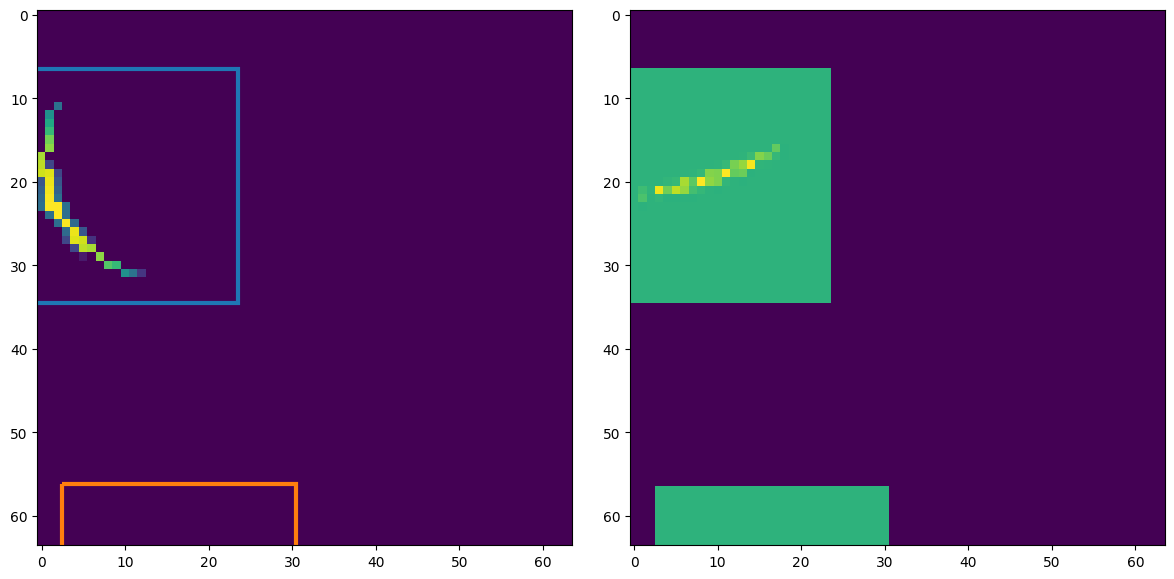

In [ ]:
particle = 8
b = 0
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
def animate(i):
  axes[0].cla()
  # axes[0].imshow(test_data[b, i])
  axes[0].imshow(foo[b, i])
  axes[1].cla()
  axes[1].imshow(out["frames_recon"][particle, b, i])
  for d in range(2):
    loc = out[f"z_where_{i}"][particle, b, d]
    # loc = jnp.array([-1, 1])
    # print(loc)
    where = 0.5 * (loc + 1) * (frame_size - 28) - 0.5
    color = colors[d]
    axes[0].add_patch(
        Rectangle(where, 28, 28, edgecolor=color, lw=3, fill=False)
    )
plt.rc("animation", html="jshtml")
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=range(10), interval=300)
writer = animation.PillowWriter(fps=15)
ani.save("worms.gif", writer=writer)
plt.show()


0.0
1.0
1.1754944e-38
0.742743
0.0
1.0
1.1754944e-38
0.75291127
0.0
1.0
1.1754944e-38
0.7494604
0.0
1.0
1.1754944e-38
0.7427127
0.0
1.0
1.1754944e-38
0.72904545
0.0
1.0
1.1754944e-38
0.75717145
0.0
1.0
1.1754944e-38
0.7186671
0.0
1.0
1.1754944e-38
0.75833505
0.0
1.0
1.1754944e-38
0.7698509
0.0
1.0
1.1754944e-38
0.7545398


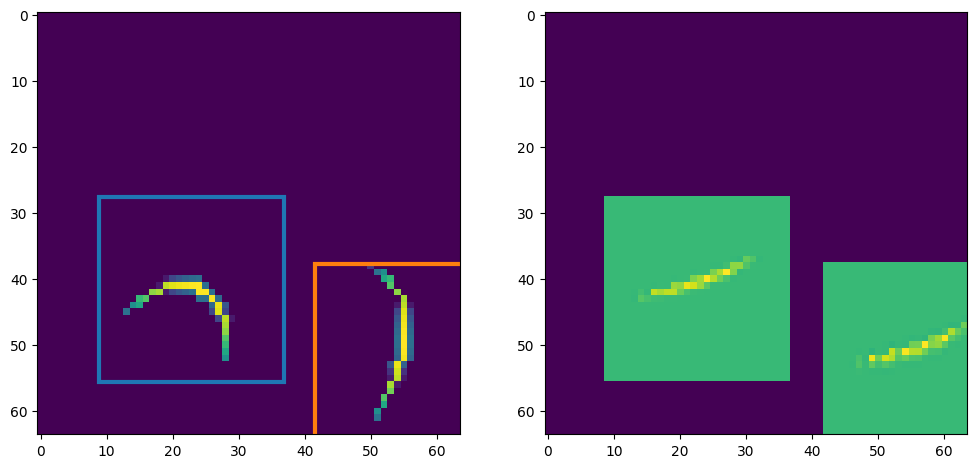

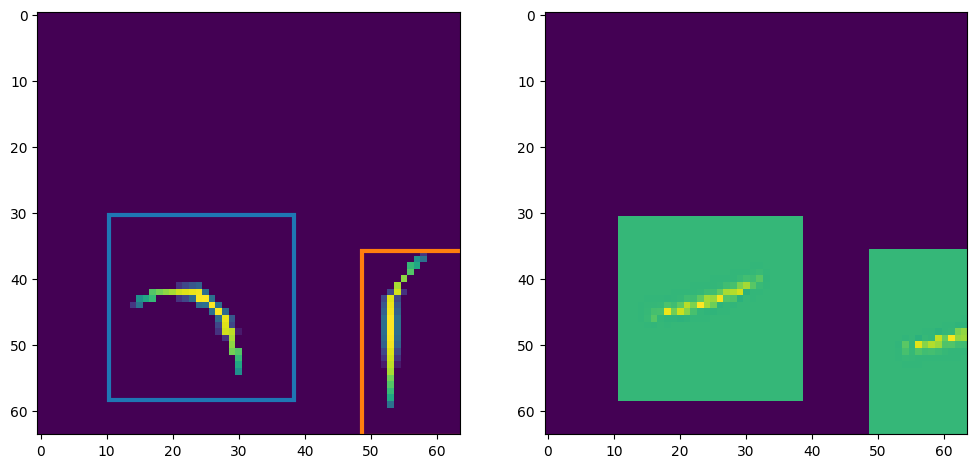

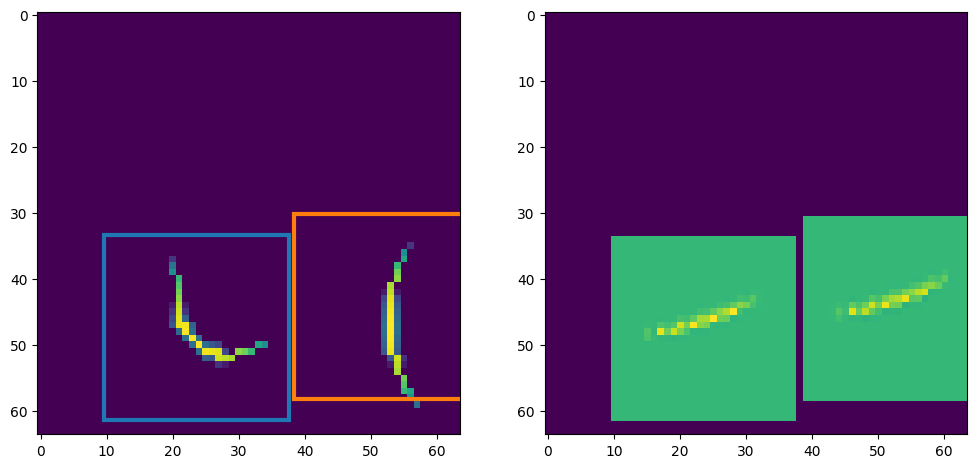

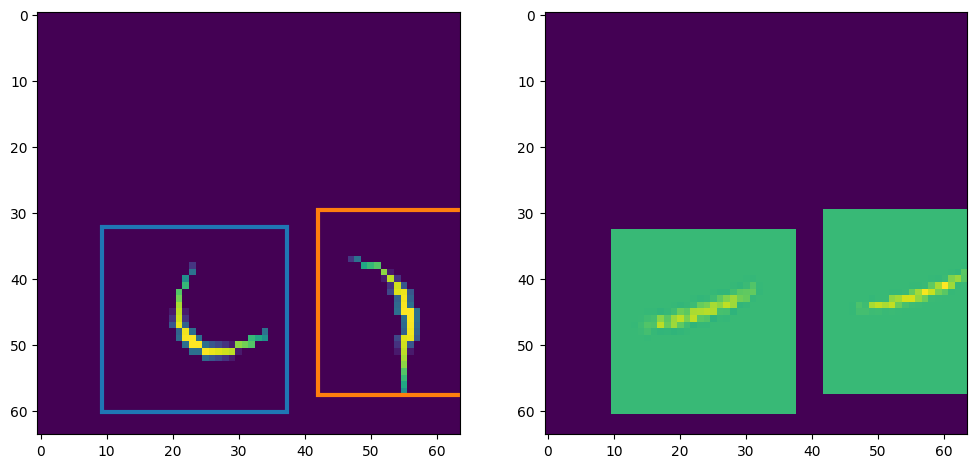

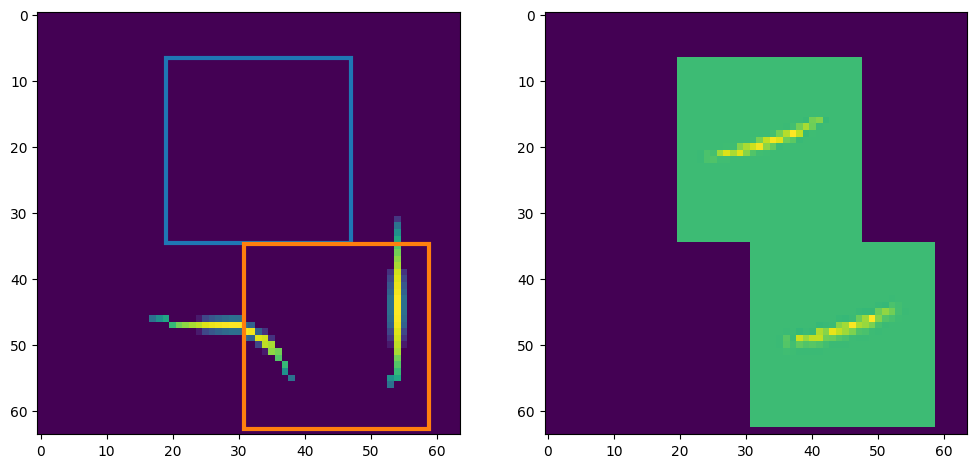

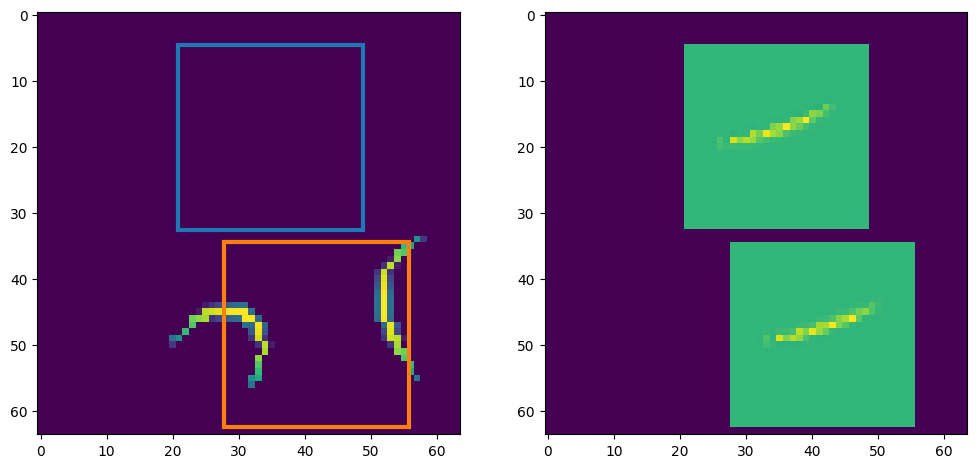

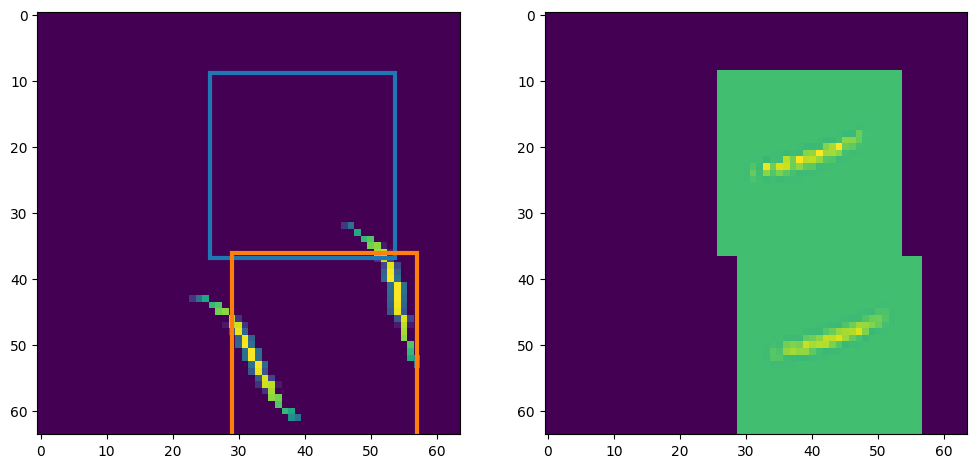

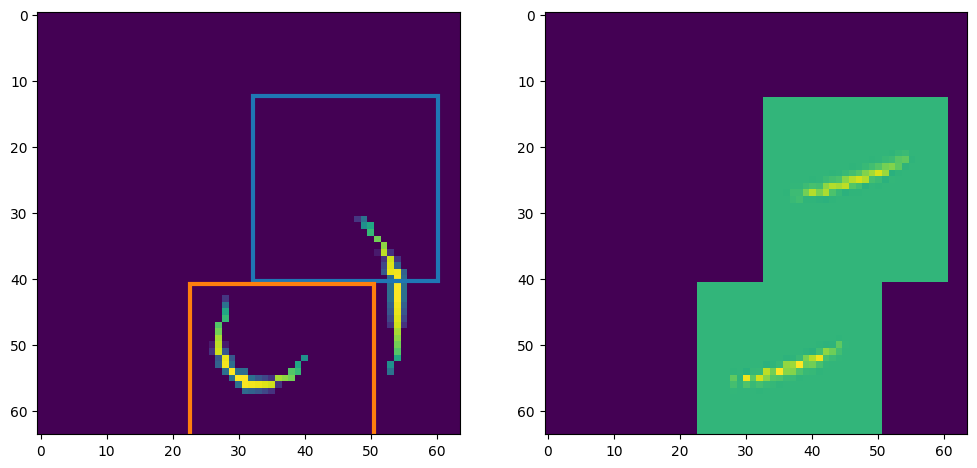

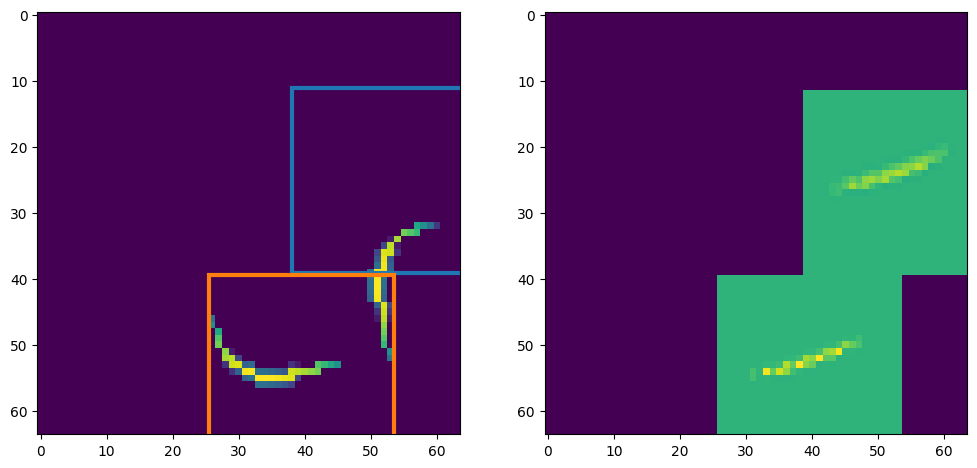

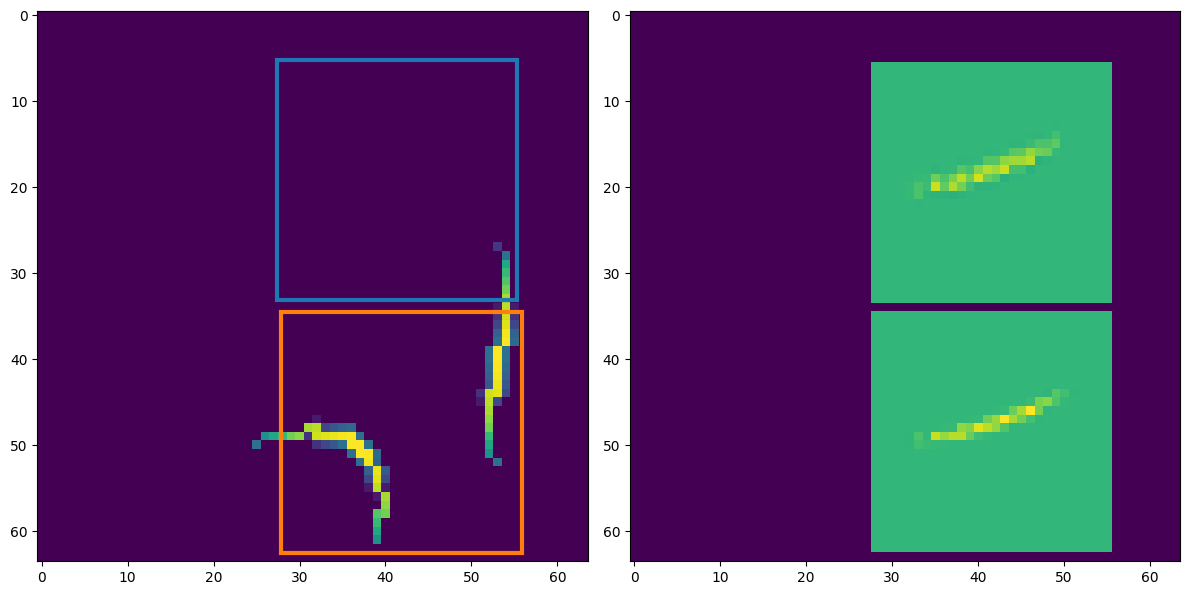

In [ ]:
b = 4
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
def animate(i):
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))
  axes[0].cla()
  # axes[0].imshow(test_data[b, i])
  axes[0].imshow(foo[b, i])
  axes[1].cla()
  axes[1].imshow(out["frames_recon"][0, b, i])
  print(test_data[b, i].min())
  print(test_data[b, i].max())
  print(out["frames_recon"][0, b, i].min())
  print(out["frames_recon"][0, b, i].max())
  for d in range(2):
    loc = out[f"z_where_{i}"][0, b, d]
    where = 0.5 * (loc + 1) * (frame_size - 28) - 0.5
    color = colors[d]
    axes[0].add_patch(
        Rectangle(where, 28, 28, edgecolor=color, lw=3, fill=False)
    )
for i in range(10):
  animate(i)
plt.rc("animation", html="jshtml")
plt.tight_layout()
# ani = animation.FuncAnimation(fig, animate, frames=range(10), interval=300)
# writer = animation.PillowWriter(fps=15)
# ani.save("wormsim.gif", writer=writer)
# plt.show()


In [ ]:
out.keys()

dict_keys(['frames', 'frames_recon', 'params', 'worm_frames', 'z_what_0', 'z_what_1', 'z_what_2', 'z_what_3', 'z_what_4', 'z_what_5', 'z_what_6', 'z_what_7', 'z_what_8', 'z_what_9', 'z_where_0', 'z_where_1', 'z_where_2', 'z_where_3', 'z_where_4', 'z_where_5', 'z_where_6', 'z_where_7', 'z_where_8', 'z_where_9'])

In [ ]:
duration = 1.55
snapshots = 10
kpoints = 6
sim_fn = partial(
        worm_simulation,
        duration=duration,
        snapshots=snapshots,
        kpoints=kpoints,
    )

In [ ]:
plt.figure()
plt.imshow(network.decode_what(foo))


AssertionError: 

<Figure size 640x480 with 0 Axes>

In [ ]:
out["z_what_0"][0, 4, 0]

Array([-0.35996825,  0.11951399, -0.21761402,  0.07139164, -0.06978504,
        0.02450009,  0.07144185, -0.02158827,  0.21532911, -0.07079058,
        0.360167  , -0.1173246 ], dtype=float32)

In [ ]:
network.params['params']['decode_what']

{'Dense_0': {'bias': Array([-4.8308535], dtype=float32),
  'kernel': Array([[-6.516733]], dtype=float32)},
 'Dense_1': {'bias': Array([0.08292505], dtype=float32),
  'kernel': Array([[0.4506103]], dtype=float32)}}

In [ ]:
nn.softplus(0.45 + 0.08) * 2

Array(1.9857125, dtype=float32, weak_type=True)

In [ ]:
nn.softplus(-6.5 -4.8) + 0.6

Array(0.6000124, dtype=float32, weak_type=True)

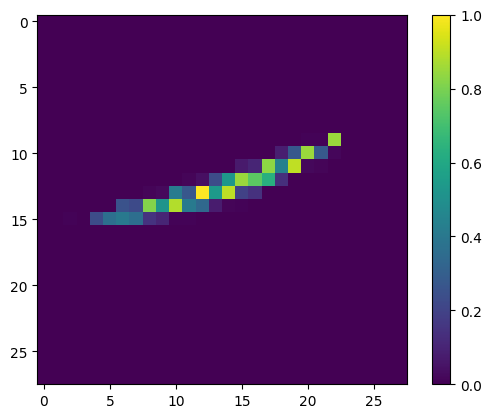

In [ ]:
plt.figure()
plt.imshow(network.decode_what(out["z_what_0"][0, 4, 0].reshape(6, 2)))
plt.colorbar()

In [ ]:
out["z_what_0"][0, 4].shape

(2, 12)